In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

In [2]:
# Define logistic function
def logistic(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))
# Define moving average function 
def simple_moving_average(w,x):
    return np.convolve(x, np.ones(w), "valid") / w

In [3]:
import numpy as np

# Replace with your actual cumulative values
cumulative_data = pd.read_csv("../params/new_psa.csv")
cumulative = cumulative_data["Cumulative Orchards"]
cumulative = np.array(list(cumulative))
incidence = np.diff(np.insert(cumulative, 0, 0))  # insert 0 at start, then take diff

In [4]:
x = np.arange(len(incidence))  # 0 through 13
y = incidence
print(y)

[ 50  25  22  16  10  15  86  88 111 467  48  31 101  73]


In [5]:
from scipy.optimize import curve_fit

# Fit to cumulative
popt, _ = curve_fit(logistic, x, cumulative, p0=[1200, 0.5, 8])
fitted_cumulative = logistic(x, *popt)

# Incidence = first difference of fitted cumulative
logistic_incidence = np.diff(np.insert(fitted_cumulative, 0, 0))
all_logistic = pd.DataFrame()
all_logistic["Cumulative Orchards"] = np.array(list(fitted_cumulative))
all_logistic["Delta Orchard"] = np.array(list(logistic_incidence))
all_logistic.to_csv("../params/log_psa.csv")

In [6]:
from scipy.stats import gamma, lognorm

x_shifted = x + 1  # avoid zero
y_norm = y / y.sum()  # normalize for PDF comparison
print(y_norm)
# Fit gamma
params_gamma = gamma.fit(y_norm, floc=0)
gamma_fit = gamma.pdf(x_shifted, *params_gamma) * y.sum()
# Fit log-normal
params_lognorm = lognorm.fit(y_norm, floc=0)
lognorm_fit = lognorm.pdf(x_shifted, *params_lognorm) * y.sum()

[0.04374453 0.02187227 0.01924759 0.01399825 0.00874891 0.01312336
 0.07524059 0.07699038 0.09711286 0.40857393 0.04199475 0.02712161
 0.08836395 0.06386702]


In [7]:
## 
seas_amounts = {'SM/11':50,'AT/11':70,'WT/11':110,'SP/11':660,'SM/12':182,'AT/12':50}
all_data = pd.read_csv("../params/new_psa.csv")
all_cuml = list(all_data["Cumulative Orchards"])
raw_incidence = np.array(all_data["Delta Orchard"])
# Recreate the corrected synthetic incidence array

In [8]:
from pandas import Series

window =2
real_inc = [incidence[i] for i in range(1,len(incidence))]
ma_smoothed = Series(real_inc).rolling(window, center=True).mean().fillna(method='bfill').fillna(method='ffill').values

#ma_smoothed = simple_moving_average(window,y)
ma_smoothed = list(ma_smoothed)
ma_smoothed.insert(0,50)
ma_smoothed = [round(x) for x in ma_smoothed]
ma_smoothed[1] = 25
# All values
window_df = pd.DataFrame()
window_df["Delta Orchard"] = ma_smoothed
window_inc = ma_smoothed
all_vals = []
total_val = 0
for i in window_inc:
    total_val += i
    all_vals.append(total_val)
all_vals[1] = 25
window_df["monthly_cuml"] = all_vals

window_df.to_csv("../params/window_psa.csv")
print(y)
print(ma_smoothed)

#difference = np.sum(y) - np.sum(ma_smoothed)
#ma_smoothed.append(difference)
#print(ma_smoothed)

[ 50  25  22  16  10  15  86  88 111 467  48  31 101  73]
[50, 25, 24, 19, 13, 12, 50, 87, 100, 289, 258, 40, 66, 87]


/tmp/ipykernel_1796669/4251254144.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ma_smoothed = Series(real_inc).rolling(window, center=True).mean().fillna(method='bfill').fillna(method='ffill').values


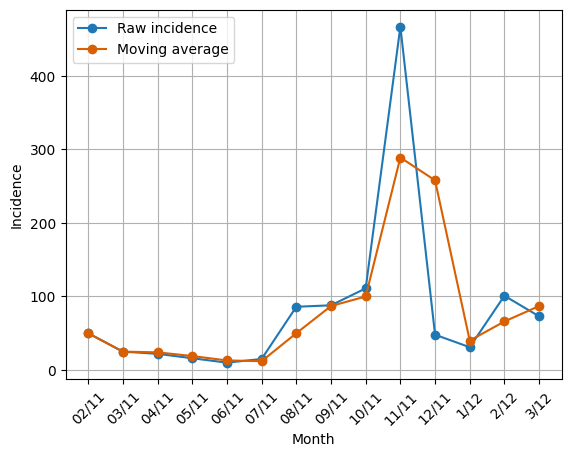

In [9]:
import matplotlib.pyplot as plt
x = ["02/11","03/11","04/11","05/11","06/11","07/11","08/11","09/11","10/11","11/11","12/11","1/12","2/12","3/12"]
colors = ['#1f78b4','#d95f02']
plt.plot(x, y, color=colors[0],marker="o",label='Raw incidence')
plt.plot(x, ma_smoothed,color=colors[1],marker="o", label='Moving average')
#plt.plot(x, logistic_incidence, 'go-', label='Logistic-derived')
#plt.plot(x, gamma_fit, 'r--', label='Gamma fit')
#plt.plot(x, lognorm_fit, 'm--', label='Log-normal fit')
#plt.plot(x, syn_inc, 'o--', label='Synthetic')

plt.tick_params(axis='x', labelrotation=45)

plt.xlabel("Month")
plt.ylabel("Incidence")
#plt.title("Comparison of Reference Incidence Curves")
plt.legend()
plt.grid(True)
#plt.show()
plt.savefig("figs/ref_curves.png")

[ 50  25  22  16  12  15  86  78 111 467  48  31 101  74]
[135.43374003   1.65250778   5.96415814]


/tmp/ipykernel_1796669/1028937650.py:3: RuntimeWarning: overflow encountered in exp
  return K / (1 + np.exp(-r * (t - t0)))


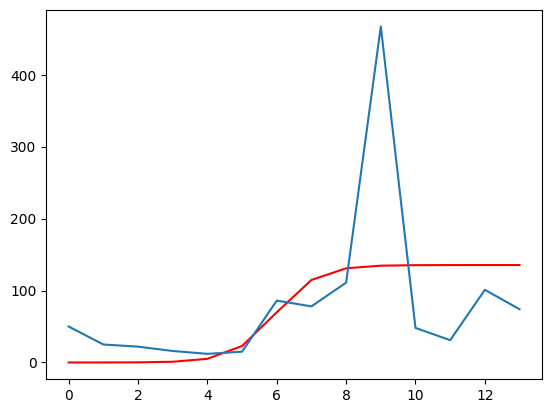

In [10]:
xdata =[i for i in range(0,14)]
xdata = np.array(xdata)
ydata = pd.read_csv("../params/new_psa.csv")
ydata = np.array(ydata["Delta Orchard"])
print(ydata)
r =  0.05
initial_guess = [1143,r, 467]
ydata = [int(i) for i in ydata]
#ydata.insert(0,26)
#ydata.insert(0,13)
#ydata.insert(0,4)
popt, pcov = curve_fit(logistic, xdata, ydata,p0=initial_guess, maxfev=500000)
print(popt)
all_dat = []
for x in xdata:
    new_val = logistic(x,*popt)
    all_dat.append(new_val)
plt.plot(xdata,logistic(xdata, *popt),'r-')
plt.plot(xdata,ydata)

In [11]:
from scipy import stats
# Try fitting different distributions
distributions = [
    ('Normal', stats.norm),
    ('Gamma', stats.gamma),
    ('Log-normal', stats.lognorm),
    ('Exponential', stats.expon)
]

#ydata =  np.array(ydata["Delta Orchard"])
# Fit each distribution and compute goodness of fit
results = []
for name, dist in distributions:
    # Fit distribution
    params = dist.fit(ydata)
    
    # Perform Kolmogorov-Smirnov test
    ks_stat, p_value = stats.kstest(ydata, dist.name, args=params)
    
    print(f"\n{name} distribution:")
    print(f"Parameters: {params}")
    print(f"KS statistic: {ks_stat:.4f}")
    print(f"P-value: {p_value:.4f}")


Normal distribution:
Parameters: (81.14285714285714, 111.76752476384515)
KS statistic: 0.3233
P-value: 0.0840

Gamma distribution:
Parameters: (0.5987928162549163, 11.999999999999998, 82.91438741821898)
KS statistic: 0.1568
P-value: 0.8306

Log-normal distribution:
Parameters: (9.731777649658603, 11.999999999999998, 2.2541274142680887)
KS statistic: 0.4403
P-value: 0.0055

Exponential distribution:
Parameters: (12.0, 69.14285714285714)
KS statistic: 0.1883
P-value: 0.6373


In [12]:
def calc_incidence(val):
    inc_vals = []
    inc_vals.append(val[0])
    for v in range(1,len(val)):
        diff = val[v] - val[v-1]
        inc_vals.append(diff)
    return inc_vals
create_data = pd.DataFrame()
create_data["Cumulative Orchards"] = all_dat
inc_data = calc_incidence(all_dat)
create_data["Delta Orchard"]=inc_data
month_vals = [v for v in range(0,len(inc_data))]
create_data["Months"] = month_vals
create_data.to_csv("../params/log_psa.csv")